<a href="https://colab.research.google.com/github/Lisa-Tera/4-1/blob/main/movie_EUN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [32]:
import tensorflow as tf
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.keras import datasets, layers, models

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


# 데이터 불러오기
train = pd.read_csv('movies_train.csv')
test = pd.read_csv('movies_test.csv')
# 결측치 확인
print(train.isnull().sum(),test.isnull().sum())

title               0
distributor         0
genre               0
release_time        0
time                0
screening_rat       0
director            0
dir_prev_bfnum    330
dir_prev_num        0
num_staff           0
num_actor           0
box_off_num         0
dtype: int64 title               0
distributor         0
genre               0
release_time        0
time                0
screening_rat       0
director            0
dir_prev_bfnum    136
dir_prev_num        0
num_staff           0
num_actor           0
dtype: int64


In [35]:
train= train[['genre', 'release_time', 'screening_rat', 'box_off_num']]

train['release_time'] = pd.to_datetime(train['release_time']).dt.month.astype(int) #year-month-day에서 month만 남도록 변경
train.head()



,genre,release_time,screening_rat,box_off_num
0,액션,1,청소년 관람불가,23398
1,느와르,1,청소년 관람불가,7072501
2,액션,1,15세 관람가,6959083
3,코미디,1,전체 관람가,217866
4,코미디,1,15세 관람가,483387


In [36]:
unique_genres = train['genre'].unique()
print(unique_genres)
#'액션' '느와르' '공포' '서스펜스' '미스터리'

['액션' '느와르' '코미디' '다큐멘터리' '뮤지컬' '드라마' '멜로/로맨스' '공포' '서스펜스' '애니메이션' '미스터리'
 'SF']


In [37]:
# 가설: 여름철 | 장르(액션,공포 등) | 청불 인 영화가 흥행할 것이다
train['genre_bi'] = train['genre'].apply(lambda x: 1 if x in ['액션', '느와르', '공포', '서스펜스', '미스터리'] else 0)
train['release_time_bi'] = train['release_time'].apply(lambda x: 1 if 7 <= x <= 9 else 0)
train['screening_rat_bi'] = train['screening_rat'].apply(lambda x: 1 if x == '청소년 관람불가' else 0)

In [39]:
#영화의 관객수가 많다는 어떤의미?
#영화의 최대 관객과 최소 관객의 차가 너무 큼
sorted_data = train.sort_values(by='box_off_num', ascending=False)
sorted_data

,genre,release_time,screening_rat,box_off_num,genre_bi,release_time_bi,screening_rat_bi
372,드라마,1,12세 관람가,14262766,0,0,0
362,느와르,1,15세 관람가,12983841,1,0,0
530,코미디,1,15세 관람가,12811435,0,0,0
498,액션,1,15세 관람가,12706663,1,0,0
460,드라마,1,15세 관람가,12323595,0,0,0
...,...,...,...,...,...,...,...
481,드라마,1,15세 관람가,36,0,0,0
410,멜로/로맨스,1,청소년 관람불가,10,0,0,1
338,멜로/로맨스,1,청소년 관람불가,8,0,0,1
324,드라마,1,청소년 관람불가,2,0,0,1


In [ ]:
top_10_avg = train['box_off_num'][train['box_off_num'] > train['box_off_num'].quantile(0.9)].mean()
mid_10_50_avg = train['box_off_num'][(train['box_off_num'] > train['box_off_num'].quantile(0.5)) &
                                     (train['box_off_num'] <= train['box_off_num'].quantile(0.9))].mean()
bottom_50_avg = train['box_off_num'][train['box_off_num'] <= train['box_off_num'].quantile(0.5)].mean()

top_10_avg, mid_10_50_avg, bottom_50_avg

(5043424.733333333, 506481.5875, 2493.286666666667)


상위 10% | 상위 10~50% | 하위 50%의 관객 수


---



In [41]:
#상위 25% 정도는 약 50만명정도로 25%를 기준으로 흥행했다고 가정
threshold = train['box_off_num'].quantile(0.75)
print("임계값 (상위 25%):", threshold)


train['box_off_num_binary'] = train['box_off_num'].apply(lambda x: 1 if x > threshold else 0)
train['box_off_num_binary'].value_counts()

임계값 (상위 25%): 479886.75


,count
box_off_num_binary,
0,450
1,150


In [ ]:
train.head()

,genre,release_time,screening_rat,box_off_num,genre_bi,release_time_bi,screening_rat_bi,box_off_num_binary
0,액션,11,청소년 관람불가,23398,1,0,1,0
1,느와르,11,청소년 관람불가,7072501,1,0,1,1
2,액션,6,15세 관람가,6959083,1,0,0,1
3,코미디,7,전체 관람가,217866,0,1,0,0
4,코미디,11,15세 관람가,483387,0,0,0,1


In [ ]:
group_1_in_train = train[(train['genre_bi'] == 0) & (train['release_time_bi'] == 0) & (train['screening_rat_bi'] == 0)]
print("train 데이터에서 group_1 조건을 만족하는 샘플 수:", len(group_1_in_train))


train 데이터에서 group_1 조건을 만족하는 샘플 수: 264


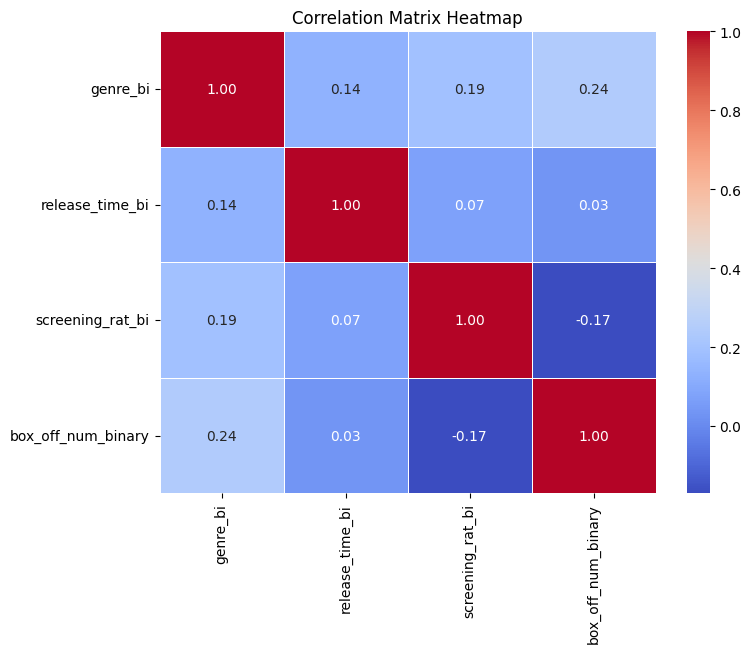

In [ ]:
#히트맵으로 각각의 상관관계 표현
correlation_matrix = train[['genre_bi', 'release_time_bi', 'screening_rat_bi','box_off_num_binary']].corr()
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Correlation Matrix Heatmap")
plt.show()

heatmap 값이 너무 낮아 경우의 수로 항목을 나눈 뒤 비교

In [ ]:
target_col = 'box_off_num_binary'
variable_groups = [
    ['genre_bi', 'release_time_bi'],
    ['release_time_bi', 'screening_rat_bi'],
    ['genre_bi', 'release_time_bi'],
    ['genre_bi', 'release_time_bi', 'screening_rat_bi']
]

# Calculate and store the correlation of each group with the target variable
correlation_results = {}
for i, variables in enumerate(variable_groups, 1):
    # Calculate the mean of the selected group as a combined feature
    combined_feature = train[variables].mean(axis=1)
    # Calculate correlation with the target column
    correlation = combined_feature.corr(train[target_col])
    correlation_results[f'Group {i} ({", ".join(variables)})'] = correlation

# Display the correlation results
correlation_results

{'Group 1 (genre_bi, release_time_bi)': 0.17600016741997726,
 'Group 2 (release_time_bi, screening_rat_bi)': -0.09713017158149025,
 'Group 3 (genre_bi, release_time_bi)': 0.17600016741997726,
 'Group 4 (genre_bi, release_time_bi, screening_rat_bi)': 0.03605689308399914}

In [ ]:
plt.figure(figsize=(8,6))
sns.scatterplot(x='box_off_num_binary[0]', y='box_off_num_binary[1]', hue='Target', data=df, palette=['blue', 'red'], alpha=0.6)

In [ ]:

X = train[['genre_bi', 'release_time_bi', 'screening_rat_bi']]
y = train['box_off_num_binary']

# 학습 및 검증 데이터 분할
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# 데이터 정규화
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)  # fit_transform은 학습 데이터에만 적용
X_val = scaler.transform(X_val)          # transform만 검증 데이터에 적용

# 딥러닝 모델 구성
model = models.Sequential([
    layers.Input(shape=(X_train.shape[1],)),  # Input 레이어
    layers.Dense(64, activation='relu'),
    layers.Dense(32, activation='relu'),
    layers.Dense(1)
])

# 모델 컴파일
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# 모델 학습
history = model.fit(X_train, y_train, epochs=50, validation_data=(X_val, y_val))

Epoch 1/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - accuracy: 0.7246 - loss: 0.5824 - val_accuracy: 0.7833 - val_loss: 0.5099
Epoch 2/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7979 - loss: 0.4902 - val_accuracy: 0.7833 - val_loss: 0.5307
Epoch 3/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7765 - loss: 0.5031 - val_accuracy: 0.7583 - val_loss: 0.5286
Epoch 4/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7952 - loss: 0.4734 - val_accuracy: 0.7583 - val_loss: 0.5270
Epoch 5/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7602 - loss: 0.5077 - val_accuracy: 0.7583 - val_loss: 0.5302
Epoch 6/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7580 - loss: 0.5390 - val_accuracy: 0.7583 - val_loss: 0.5162
Epoch 7/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7601 - loss: 0.5252 - val_accuracy: 0.7583 - val_loss: 0.5198
Epoch 8/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7876 - loss: 0.4902 - val_accuracy: 0.7833 - val_loss

In [ ]:
from sklearn.metrics import classification_report

y_pred = (model.predict(X_val) > 0.5).astype("int32")
print(classification_report(y_val, y_pred))


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
              precision    recall  f1-score   support

           0       0.79      0.97      0.87        90
           1       0.70      0.23      0.35        30

    accuracy                           0.78       120
   macro avg       0.75      0.60      0.61       120
weighted avg       0.77      0.78      0.74       120

